In [1]:
import numpy as np
alldeploys=["Wizard","ManaTower","Executioner","Ghost"]
allabilities=["Fireball","Execute","Haunt","Nuke"]
allnotarget=["HealSpell","ExorcismSpell","ThornSpell"]
allmoves=['EndTurn']
alldeploysquares=[]
allhandcards=alldeploys+allnotarget
for card in alldeploys:
    alldeploysquares.extend([card+str(x) for x in range(4)])
allmoves.extend(alldeploysquares)
for move in allabilities:
    allmoves.extend([move+str(x) for x in range(4)])
allmoves.extend([allnotarget[x] for x in range(2)])
def encodehand(hand,length=len(allhandcards)):
    small=len(allhandcards)
    return [hand.count(x) if x in hand else 0 for x in allhandcards]+[0]*max(0,length-small)
def encodemove(move,length=len(allmoves)):
    small=len(allmoves)
    return [1 if x==move else 0 for x in allmoves]+[0]*max(0,length-small)
def encodemoves(moves,length=len(allmoves)):
    small=len(allmoves)
    return [1 if x in moves else 0 for x in allmoves]+[0]*max(0,length-small)
def encodedeployed(troops,length=len(alldeploysquares)):
    small=len(alldeploysquares)
    return [1 if x in troops else 0 for x in alldeploysquares]+[0]*max(0,length-small)
def encodehealths(troops):

    return [troop.health if hasattr(troop,"health") else 0 for troop in troops]+[0]*(4-len(troops))
snapshot = {

    "My_Mana": [0],
    "Their_Mana": [0],
    "My_Health": [0],
    "Their_Health": [0],
    "Their_Card_Types_Seen":encodehand([0]),
    "Their_Currently_Visible_Cards": encodedeployed([0,0,0,0]),
    "Their_cardhealths":[0]*4,
    "Your cardhealths":[0]*4,
    "Active_Cards":encodedeployed([0,0,0,0]),
    "Deck":encodehand([]),
    "Action Taken":encodemove([])
}

information=[]
for key in snapshot.keys():
    information.extend(snapshot[key])
infolength=len(information)
infolength

93

In [2]:
import time
# -----------------------------
# Game controller
# -----------------------------
class Game:
    def __init__(self, player_1, player_2, length=10, prnt=True, offset=[0,2],show=False):
        self.turn = 0
        self.prnt = prnt
        self.moves_played = 0
        self.length = length
        self.game_over = False
        self.players = [player_1, player_2]
        
        player_1.game = self
        player_2.game = self
        player_1.inform_cards()
        player_2.inform_cards()
        player_1.team = 0
        player_2.team = 1
        player_2.base_health += offset[0]
        player_2.mana += offset[1]
        self.boards=[]
        self.show=show
        self.player_1=player_1
        self.player_2=player_2
    def change_turn(self):
        self.turn = 1 - self.turn

    def play(self):
        start=time.time()
        while self.moves_played < self.length and not self.game_over:
            player = self.players[self.turn]
            opponent = self.players[self.turn-1]
            if self.prnt:
                print(f"\n--- Turn {self.moves_played}, Player {self.turn+1} ---")
            player.make_move(self)
            if self.show:
                self.show_board()
            if time.time()-start>20:
                return self.end_game()
            
        return self.end_game()

    def end_game(self):
        p1, p2 = self.players
        if p1.base_health > p2.base_health:
            return 1
        elif p1.base_health < p2.base_health:
            return -1
        return 0
    def show_board(self):
        print("----------------------------------------------")
        print("Current Board:")
        print(f"Player 2 Health:{self.player_2.base_health}")
        print(f"Player 2 Mana:{self.player_2.mana}")
        print("Player 2 cards in hand:")
        print(*[card.name for card in self.player_2.deck])
        print("Player 2 troops deployed:")
        print(*[square.troop.name if not square.empty else "____" for square in self.player_2.available_squares])
        print("Player 1 troops deployed:")
        print(*[square.troop.name if not square.empty else "____" for square in self.player_1.available_squares])
        print("Player 1 cards in hand:")
        print(*[card.name for card in self.player_1.deck])
        print(f"Player 1 Health:{self.player_1.base_health}")
        print(f"Player 1 Mana:{self.player_1.mana}")
        print("----------------------------------------------")

In [3]:
from collections import deque
# -----------------------------
# GamePlayer
# -----------------------------
class GamePlayer:
    def __init__(self, difficulty, game, deck, decision_maker,length=len(allmoves)):
        self.difficulty = difficulty
        self.game = game
        # Start with the full deck as "largedeck"
        self.largedeck = deque(deepcopy(deck))
        
        self.deck = []  # current hand (max 5)
        self.active_cards = []
        self.decision_maker = decision_maker
        self.team = None
        self.available_squares = [Square(i) for i in range(4)]
        self.mana = 30
        self.base_health = 15
        # draw initial hand
        self.draw_cards()
        self.move="EndTurn"
        snapshot = {
           
            "My_Mana": [self.mana],
            "Their_Mana": [self.mana],
            "My_Health": [self.base_health],
            "Their_Health": [self.base_health],
            "Their_Card_Types_Seen":encodehand([0]),
            "Their_Currently_Visible_Cards": encodedeployed([0,0,0,0]),
            "Their_cardhealths":[0]*4,
            "Your cardhealths":[0]*4,
            "Active_Cards":encodedeployed([0,0,0,0]),
            "Deck":encodehand(self.deck),
            "Action Taken":encodemove(self.move)
        }
        self.information=[]
        for key in snapshot.keys():
            self.information.extend(snapshot[key])
        self.known_enemy_types = set()
        self.passive_effectors=[]
    def inform_cards(self):
        for card in self.largedeck:
            card.gain_player(self)
        for card in self.deck:
            card.gain_player(self)
        for card in self.active_cards:
            card.gain_player(self)
    def clone(self):
        return deepcopy(self)

    def draw_cards(self):
        """Refill hand up to 5 cards from largedeck."""
        while len(self.deck) < 5 and self.largedeck:
            
            self.deck.append(self.largedeck.pop())

    def refresh_deck(self):
        """Call this at the start of a turn to ensure 5 cards in hand."""
        self.draw_cards()

    def get_possible_moves(self, game):
        moves = [EndTurnMove(self)]
        # Only consider cards that are alive
        extend_deck = [c for c in self.deck + self.active_cards]

        for card in extend_deck:
            moves.extend(card.get_possible_moves(game,self))

        return moves

    def make_move(self, game):
        self.inform_cards()
        moves = self.get_possible_moves(game)
        if moves:
            move = self.decision_maker.choose_move(moves,self.information)
            self.move=move.movename
            move.execute(game)
    

    def record_information(self, game,opponent,length=len(allmoves)):
        
        visible_enemy_cards = [c for c in opponent.active_cards if not getattr(c, "hidden", False)]

        # update memory of seen types
        self.known_enemy_types.update(c.name+str(c.square.index) for c in visible_enemy_cards)
        
        enemy_list=list(self.known_enemy_types) +[0]*(length-len(self.known_enemy_types))
        
        snapshot = {
           
            "My_Mana": [int(self.mana)],
            "Their_Mana": [int(opponent.mana)],
            "My_Health": [int(self.base_health)],
            "Their_Health": [int(opponent.base_health)],
            "Their_Card_Types_Seen":encodehand(enemy_list) ,
            "Their_Currently_Visible_Cards": encodedeployed([square.troop.name+str(square.index) if not square.empty else 0 for square in opponent.available_squares]),
            "Their_cardhealths":encodehealths(opponent.active_cards),
            "Your cardhealths":encodehealths(self.active_cards),
            "Active_Cards":encodedeployed([square.troop.name+str(square.index) if not square.empty else 0 for square in self.available_squares]),
            "Deck":encodehand([c.name for c in self.deck]),
            "Action Taken":encodemove(self.move)
            
        }
      
        self.information=[]
        for key in snapshot.keys():
            self.information.extend(snapshot[key])
    def invigorate(self):
        for card in self.active_cards:
            card.exhausted=False
    def employ_effects(self):
        for effect in self.passive_effectors:
            effect.tick(self)

In [4]:
class Effect:
    def __init__(self, owner, source=None):
        self.owner = owner      # usually the player
        self.source = source    # the troop or item that caused this effect
        self.active = True

    def tick(self, effects):
        pass


class ManaTowerEffect(Effect):
    def tick(self,player):
        if player.game.prnt:
            print(f"{self.source.name} grants +1 mana.")
        self.owner.mana += 1
class HiddenThornmailEffect(Effect):
    def tick(self,card,caster,damage):
        caster.take_damage(card,damage,reflected=True)
        if card.prnt:
            print(f"Damage reduced from {damage} to {damage-2}")
        damage=max(0,damage-2)
        card.damage=damage
            
        
        if self in card.defeffects:
            card.defeffects.remove(self)
        self.active=False
        self.owner.largedeck.appendleft(ThornCard(card.team))
        
        
        
    

In [5]:
from abc import ABC, abstractmethod
from copy import deepcopy

# -----------------------------
# Card base class
# -----------------------------
class Card(ABC):
    def __init__(self, type_="", team=0, mana_cost=0, name="", hidden=False):
        self.type = type_
        self.team = team
        self.mana_cost = mana_cost
        self.name = name
        self.hidden = hidden
        self.deployed = False
        self.dead = False
        self.square = None
        self.exhausted=False
        self.health=0
        self.initial_health=0
        self.defeffects=[]
        self.player=None
        self.game=None
        self.prnt=False
    def get_possible_moves(self, game):
        pass
    def gain_player(self,player):
        self.player=player
        self.game=player.game
        self.prnt=self.game.prnt
    def die(self,player):
        """Troop dies and returns to largedeck for reuse."""
        if player is None:
            return
        self.deployed = False
        if self in player.active_cards:
            player.active_cards.remove(self)
        if self.square:
            self.square.troop=None
            self.square.empty=True
        if self in player.deck:
            player.deck.remove(self)
        player.largedeck.appendleft(self)  # Recycle the card
        self.square = None
        self.health=self.initial_health
    def take_damage(self,caster,damage ,reflected=False):
        if self.square is None or not self.deployed:
            return
        self.damage=damage
        if not reflected:
            for effect in self.defeffects.copy():
                
                effect.tick(self,caster,self.damage)
        self.health-=self.damage
        if self.prnt:
            print(f"Player{self.team+1}'s {self.name} on Square {self.square.index} took {self.damage} damage! {self.health} remaining. ")
        if self.health<=0:
            self.die(self.player)
            if self.prnt:
                print("It died!")
# -----------------------------
# WizardCard
# -----------------------------
class WizardCard(Card):
    def __init__(self, team=0):
        super().__init__(type_="troop", team=team, mana_cost=6,name="Wizard")
        self.initial_health=8
        self.health = 8
        self.hidden=False
        self.exhausted=False
        self.ability_cost=6

    def get_possible_moves(self, game,player):
        
        moves = []
        if not self.deployed and player.mana>=self.mana_cost:
            for sq in player.available_squares:
                if sq.empty:
                    moves.append(DeployTroopMove(self, sq,player))
        else:
            opponent = game.players[1 - player.team]
            if player.mana >= self.ability_cost and not self.exhausted and self.deployed:
                for sq in opponent.available_squares:
                    moves.append(FireballMove(self, sq,player))
        return moves
class ThornCard(Card):
    def __init__(self, team=0):
        super().__init__(type_="spell", team=team, mana_cost=4,name="ThornSpell")
        self.initial_health=100
        self.health = 100
        self.hidden=False
        self.exhausted=False
        self.ability_cost=100
    def get_possible_moves(self, game,player):
        
        moves = []
        if player.mana>=self.mana_cost:
            for sq in player.available_squares:
                if not sq.empty:
                    
                    if not any(type(x) is HiddenThornmailEffect for x in sq.troop.defeffects):
                        
                        moves.append(ThornMove(self, sq,player))
                        
        return moves

# -----------------------------
# WizardCard
# -----------------------------
class GhostCard(Card):
    def __init__(self, team=0):
        super().__init__(type_="troop", team=team, mana_cost=4, name="Ghost")
        self.health = 4
        self.initial_health=4
        self.hidden=True
        self.exhausted=False
        self.ability_cost=2
        self.damage=1
        
    def get_possible_moves(self, game,player):
        self.player = player
        moves = []
        if not self.deployed and player.mana>=self.mana_cost:
            for sq in player.available_squares:
                if sq.empty:
                    moves.append(DeployTroopMove(self, sq,player))
        else:
            opponent = game.players[1 - player.team]
            if player.mana >= self.ability_cost and not self.exhausted and self.deployed:
                for sq in opponent.available_squares:
                    moves.append(HauntMove(self,sq,self.damage,self.ability_cost,player))

        return moves
    def die(self,player):
        self.ability_cost=2
        self.damage=1
        super().die(player)
        
        

class HealCard(Card):
    def __init__(self, team=0):
        super().__init__(type_="spell", team=team, mana_cost=3, name="HealSpell")
        self.health = 1000
        self.hidden=True
        self.exhausted=False
        self.ability_cost=1000
    def get_possible_moves(self, game, player):
        self.player = player
        

        opponent = game.players[1 - player.team]
        if player.mana >= self.mana_cost and not self.exhausted:
             

            return [HealMove(self,player)]
        return []
class ExorcismCard(Card):
    def __init__(self, team=0):
        super().__init__(type_="spell", team=team, mana_cost=4, name="ExorcismSpell")
        self.health = 1000
        self.hidden=True
        self.exhausted=False
        
    def get_possible_moves(self, game, player):
        self.player = player
        

        opponent = game.players[1 - player.team]
        if player.mana >= self.mana_cost and not self.exhausted:
             

            return [ExorcismMove(self,player)]
        return []

In [6]:

class NukeCard(Card):
    def __init__(self, team=0):
        super().__init__(type_="spell", team=team, mana_cost=12, name="NukeSpell")
        self.health = 1000
        self.hidden=True
        self.exhausted=False
        self.ability_cost=1000
    def get_possible_moves(self, game, player):
        self.player = player
        

        opponent = game.players[1 - player.team]
        if player.mana >= self.mana_cost and not self.exhausted:
             

            return [NukeMove(self,player)]
        return []

In [7]:
# -----------------------------
# ExecutionerCard
# -----------------------------
class ExecutionerCard(Card):
    def __init__(self, team=0):
        super().__init__(type_="troop", team=team, mana_cost=4,name="Executioner")
        self.initial_health=8
        self.health = 8
        self.hidden=False
        self.exhausted=False
        self.ability_cost=2
        self.execution_threshold=60

    def get_possible_moves(self, game, player):
        self.player = player
        moves = []
        if not self.deployed and player.mana>=self.mana_cost:
            for sq in player.available_squares:
                if sq.empty:
                    moves.append(DeployTroopMove(self, sq,player))
        else:
            opponent = game.players[1 - player.team]
            if player.mana >= self.ability_cost and not self.exhausted and self.deployed:
                for sq in [square for square in opponent.available_squares if not square.empty and not square.troop.hidden]:
                    if sq.troop.health<=.01*self.execution_threshold*sq.troop.initial_health:
                        moves.append(ExecutionerMove(self, sq,player))
        return moves

# -----------------------------
# ExecutionerCard
# -----------------------------

In [8]:
class ManaTowerCard(Card):
    def __init__(self,team=0):
        super().__init__(type_="troop",team=team,mana_cost=4,name="ManaTower")
        self.initial_health=7
        self.health=self.initial_health
        self.hidden=False
        self.exhausted=False
        self.ability_cost=6
        self.effect=None
        self.deployed=False
    def get_possible_moves(self, game, player):
        self.player = player
        moves = []
        if not self.deployed and player.mana>=self.mana_cost:
            for sq in player.available_squares:
                if sq.empty:
                    moves.append(DeployManaTowerMove(self, sq,player))
        return moves
    def die(self,player):
         
        super().die(player)
        if self.effect in player.passive_effectors:
            player.passive_effectors.remove(self.effect)
        

In [9]:
# -----------------------------
# Square and BuffSquare
# -----------------------------
class Square:
    def __init__(self, index, troop=Card()):
        self.index = index
        self.troop = troop
        self.empty = True

class BuffSquare:
    def __init__(self):
        self.empty = True

In [10]:
# -----------------------------
# Move base class
# -----------------------------
class Move(ABC):
    @abstractmethod
    def execute(self, game):
        pass

# -----------------------------
# DeployTroopMove
# -----------------------------
class DeployTroopMove(Move):
    def __init__(self, card, square,player):
        self.card = card
        self.square = square
        self.mana_cost = card.mana_cost
        self.player=player
        self.type="Deploy"
        self.movename=card.name+str(square.index)
    def execute(self, game):
        player=self.player
        if self.player.mana < self.mana_cost:
            if game.prnt:
                print(f"❌ Not enough mana to deploy {self.card.name}!")
                print(f" Mana needed: {self.mana_cost} Current Mana: {player.mana}")
            return
        player.mana -= self.mana_cost
        self.square.troop = self.card
        self.square.empty = False
        self.card.deployed = True
        self.card.square = self.square
        if self.card in player.deck:
            player.deck.remove(self.card)
        player.active_cards.append(self.card)
        player.move_played=(self.card.name,self.square.index)
        if game.prnt:
            print(f"🧙 {self.card.name} deployed on square {self.square.index}. Mana: {player.mana}")
class DeployManaTowerMove(Move):
    def __init__(self, card, square,player):
        self.card = card
        self.square = square
        self.card.effect=ManaTowerEffect(player,card)
        self.player=player
        self.mana_cost=self.card.mana_cost
        self.type="Deploy"
        self.movename=card.name+str(square.index)
    def execute(self, game):
        player=self.player
        if self.player.mana < self.mana_cost:
            if game.prnt:
                print(f"❌ Not enough mana to deploy {self.card.name}!")
                print(f" Mana needed: {self.mana_cost} Current Mana: {player.mana}")
            return
        player.mana -= self.mana_cost
        self.square.troop = self.card
        self.square.empty = False
        self.card.deployed = True
        self.card.square = self.square
        if self.card in player.deck:
            player.deck.remove(self.card)
        player.active_cards.append(self.card)
        if game.prnt:
            print(f"🧙 {self.card.name} deployed on square {self.square.index}. Mana: {player.mana}")
        self.player.passive_effectors.append(self.card.effect)
class ThornMove(Move):
    def __init__(self, card, square,player):
        self.card = card
        self.square = square
        self.card.effect=HiddenThornmailEffect(player,card)
        self.player=player
        self.mana_cost=self.card.mana_cost
        self.type="Spell"
        self.movename=card.name+str(square.index)
    def execute(self,game):
        if self.card.effect in self.square.troop.defeffects:
            return
        self.square.troop.defeffects.append(self.card.effect)
        self.player.deck.remove(self.card)
        self.player.mana-=self.mana_cost
        if self.player.game.prnt:
            print(f"Thorn spell casted on player{self.player.team+1}'s {self.square.troop.name} on square {self.square.index}")
        
        

class FireballMove(Move):
    def __init__(self, caster, target_square,player):
        self.caster = caster
        self.target_square = target_square
        self.mana_cost = caster.ability_cost
        self.player=player
        self.type="DamageAbility"
        self.name="Fireball"
        self.movename=self.name+str(target_square.index)
    def execute(self, game):
        player=self.player
        if player.mana < self.mana_cost and not self.caster.exhausted:
            if game.prnt:
                print("❌ Not enough mana for fireball!")
                print(f" Mana needed: {self.mana_cost} Current Mana: {player.mana}")
            return
        player.mana -= self.mana_cost
        opponent = game.players[1 - player.team]
        squares = opponent.available_squares
        idx = squares.index(self.target_square)
        self.caster.exhausted=True

        if game.prnt:
            print(f"Player{player.team+1}'s Wizard on square {self.caster.square.index} casts Fireball at enemy square {idx}! Mana left: {player.mana}")

        splash_indices = [i for i in [idx-1, idx, idx+1] if 0 <= i < len(squares)]
        splash_damage = 6 / len(splash_indices)
        overkill = 0

        for i in splash_indices:
            sq = squares[i]
            if not sq.empty and sq.troop and hasattr(sq.troop, "health") and not sq.troop.dead:
                sq.troop.take_damage(self.caster,splash_damage)
                
                    
                if hasattr(sq.troop, "health"): 
                    if sq.troop.health <= 0:
                        overkill += -sq.troop.health
                        
                        sq.troop.die(opponent)
                        sq.troop = None
                        sq.empty = True
            else:
                overkill += splash_damage  # hitting empty square counts as overkill

        if overkill > 0:
            opponent.base_health -=overkill
            if game.prnt:
                print(f"🏰 {overkill:.1f} overkill damage to opponent base! Remaining: {opponent.base_health:.1f}")

        if opponent.base_health <= 0:
            if game.prnt:
                print("🎉 Opponent base destroyed! Game over.")
            game.game_over = True
class HauntMove(Move):
    def __init__(self, caster, target_square,damage,mana_cost,player):
        self.caster = caster
        self.target_square = target_square
        self.mana_cost = mana_cost
        self.damage=damage
        self.player=player
        self.type="DamageAbility"
        self.name="Haunt"
        self.movename=self.name+str(target_square.index)
    def execute(self, game):
        player=self.player
        if player.mana < self.mana_cost and not self.caster.exhausted:
            if game.prnt:
                
                print("❌ Not enough mana for haunt!")
                print(f" Mana needed: {self.mana_cost} Current Mana: {player.mana}")
            return
        player.mana -= self.mana_cost
        opponent = game.players[1 - player.team]
        squares = opponent.available_squares
        idx = squares.index(self.target_square)
        self.caster.exhausted=True

        if game.prnt:
            print(f"Player{player.team+1}'s Ghost on square {self.caster.square.index} casts Haunt at enemy square {idx}! Mana left: {player.mana}")

        
        if not self.target_square.empty:
            self.target_square.troop.take_damage(self.caster,self.damage)
            
            
                
        
            
            
        

        
        if game.prnt:
            print(f" {self.damage} damage to opponent base! Remaining: {opponent.base_health:.1f}")    
        self.caster.damage+=1
        self.caster.ability_cost+=2
        opponent.base_health-=self.damage
        

        if opponent.base_health <= 0:
            if game.prnt:
                print("🎉 Opponent base destroyed! Game over.")
            game.game_over = True
class HealMove(Move):
    def __init__(self,card,player):
        self.card=card
        self.player=player
        self.mana_cost = card.mana_cost
        self.type="NoTargetSpell"
        self.movename=card.name
    def execute(self, game):
        self.player.mana-=self.mana_cost
        if game.prnt:
            print(f"Player {self.player.team+1} casts heal!")
        if self.player.active_cards:
            for card in self.player.active_cards:
                card.health = card.health+2
                if game.prnt and card.square:
                    print(f"Player {self.player.team+1}'s {card.name} on square {card.square.index} is now {card.health} hp!")
        else:
            self.player.base_health+=1
            if game.prnt:
                print(f"Player {self.player.team+1}'s base is healed! Remaining Health:{self.player.base_health} hp!")
            
                  
                
        
            
        self.card.die(self.player)
class ExorcismMove(Move):
    def __init__(self,card,player):
        self.card=card
        self.player=player
        self.mana_cost = card.mana_cost
        self.type="NoTargetSpell"
        self.movename=card.name
    def execute(self, game):
        opponent=game.players[1-self.player.team]
        self.player.mana-=self.mana_cost
        if game.prnt:
            print(f"Player {self.player.team+1} casts Exorcism!")
        if opponent.active_cards:
            for square in opponent.available_squares:
                if not square.empty:
                    if square.troop.name=="Ghost":
                        if game.prnt :
                            print(f"Player {opponent.team+1}'s {square.troop.name} on square {square.index} has been Exorcised!")

                        square.troop.die(opponent)
        elif game.prnt:
            print(f"No ghosts deployed!")
           
            
                  
                
        
            
        self.card.die(self.player)
class NukeMove(Move):
    def __init__(self,card,player):
        self.card=card
        self.player=player
        self.mana_cost = card.mana_cost
        self.type="NoTargetSpell"
        self.movename=card.name
    def execute(self, game):
        opponent=game.players[1-self.player.team]
        self.player.mana-=self.mana_cost
        if game.prnt:
            print(f"Player {self.player.team+1} casts Nuke!")
        if opponent.active_cards:
            for square in opponent.available_squares:
                if not square.empty:
                    
                    if game.prnt :
                        print(f"Player {opponent.team+1}'s {square.troop.name} on square {square.index} got cooked.")
                    square.troop.die(opponent)
        opponent.base_health-=2
        if game.prnt :
            print(f"Player {opponent.team+1}'s base got blasted!{opponent.base_health} hp remaining.")
        self.card.die(self.player)
       
# -----------------------------
# EndTurnMove
# -----------------------------
class EndTurnMove(Move):
    def __init__(self, player):
        self.player = player
        self.type="EndTurn"
        self.movename="EndTurn"

    def execute(self, game):
        # End the current player's turn first
        game.change_turn()
        game.moves_played += 1

        # Refresh the new player's deck and info
        new_player = game.players[game.turn]
        old_player = game.players[1 - game.turn]

        old_player.mana += 2
        old_player.refresh_deck()

        
        new_player.invigorate()
        new_player.refresh_deck()
        
        

        if game.prnt:
            print(f"Player {old_player.team+1} ends turn and gains 2 mana.")
        old_player.employ_effects()
        new_player.record_information(game,old_player)
        if game.prnt:
            print(f"Player {old_player.team+1} has {old_player.mana} mana remaining.")

In [11]:
class ExecutionerMove(Move):
    def __init__(self, caster, target_square,player):
        self.caster = caster
        self.target_square = target_square
        self.mana_cost = caster.ability_cost
        self.player=player
        self.execution_threshold=caster.execution_threshold
        self.type="DamageAbility"
        self.name="Execute"
        self.movename=self.name+str(target_square.index)
    def execute(self, game):
        executionThreshhold = self.execution_threshold ######<--PERCENT health threshhold for execution to instantly kill enemy unit-->#####
        sq = self.target_square
        player=self.player
        if player.mana < self.mana_cost and not self.caster.exhausted:
            if game.prnt:
                print("❌ Not enough mana/weak targets for execution!")
                print(f" Mana needed: {self.mana_cost} Current Mana: {player.mana}")
            return
        if game.prnt:
            print(f"Player{player.team+1}'s Executioner on square {self.caster.square.index} casts Execute at enemy square {self.target_square.index}! ")
        if sq.empty or not sq.troop or not hasattr(sq.troop, "health") or sq.troop.dead:
            if game.prnt:
                print("❌ No targets for execution!")
            return
        if self.target_square.troop.health >= self.target_square.troop.initial_health * (executionThreshhold * 0.01) :
            if game.prnt:
                print("Target is not weak enough for Executioner to execute")
            return
        if game.prnt:
            print(f"Executioner executes {self.target_square.troop.name}  !!! OWNED!!!!")
        
        player.mana -= self.mana_cost
        opponent = game.players[1 - player.team]
        opponent.base_health-=2
        if game.prnt:
            print(f"Player {opponent.team+1}'s base takes 2 damage! {opponent.base_health} hp remaining!'")
        squares = opponent.available_squares
        idx = squares.index(self.target_square)
        self.caster.exhausted=True
        self.target_square.troop.die(opponent)
        self.target_square.troop = None
        self.target_square.empty = True
        if game.prnt:
            print(f"Mana left: {player.mana}")
       

        if opponent.base_health <= 0:
            if game.prnt:
                print("🎉 Opponent base destroyed! Game over.")
            game.game_over = True

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RecurrentPolicy(nn.Module):
    def __init__(self, input_dim, hidden_dim, action_dim):
        super().__init__()

        self.fc_in = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, action_dim)

    def forward(self, obs, hidden, action_mask):
        """
        obs: (batch, seq_len, input_dim)
        hidden: (h, c) or None
        action_mask: (batch, action_dim)
        """

        x = F.relu(self.fc_in(obs))        # (batch, seq_len, hidden)
        x, hidden = self.lstm(x, hidden)  # x: (batch, seq_len, hidden)

        last_output = x[:, -1]            # use last timestep
        logits = self.fc_out(last_output) # (batch, action_dim)

        # mask illegal actions with -inf
        logits = logits.masked_fill(action_mask == 0, float('-inf'))

        probs = F.softmax(logits, dim=-1)
        return probs, hidden

In [13]:
def onehotmoves(moves):
        #function takes in a list of move instances and gives a onehot encoding of each
        movenames=[move.movename for move in moves]#contains the NAMES of moves rather than instances ex:"Wizard1" 
        movelist=encodemoves(movenames)#one-hot encoded list of possible moves

        return movelist
def convertanswer(possible_moves, action_index):
    # lookup name of the global move at this index
    movename = allmoves[action_index]

    # find the move instance in the legal list
    for move in possible_moves:
        if move.movename == movename:
            return move

    # fallback (should never happen)
    return possible_moves[0]
    

# -----------------------------
# DecisionMaker (random for now)
# -----------------------------
class DecisionMaker():
    def __init__(self):
        pass
    def reset(self):
        pass
class DumbDecisionMaker(DecisionMaker):
    def __init__(self,name="Dummy"):
       
        self.name=name
    def choose_move(self,possible_moves,information):
        return np.random.choice(possible_moves)
        
class NeuralDecisionMaker(DecisionMaker):
    def __init__(self, policy=None,state_dim=infolength, hidden_dim=128, action_dim=len(allmoves), name="BigBrain"):
            
        if policy is None:
                
            self.policy = RecurrentPolicy(input_dim=state_dim,
                                         hidden_dim=hidden_dim,
                                         action_dim=action_dim)
        else:
            self.policy=policy
                
        self.name = name
        self.trajectory = []
        self.hidden = None  # LSTM hidden state
    def reset(self):
        self.hidden = None    # call this at episode start

    def choose_move(self, possible_moves, information):
        # information is your flat 87-dim state
        state = torch.tensor(information, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        # shape = (1, 1, 87)

        action_mask = torch.tensor(onehotmoves(possible_moves), dtype=torch.float32).unsqueeze(0)
        # shape = (1, 37)

        # forward LSTM
        probs, self.hidden = self.policy(state, self.hidden, action_mask)

        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        # save log-prob for REINFORCE
        self.trajectory.append({
            "log_prob": dist.log_prob(action),
        })

        return convertanswer(possible_moves, action.item())
def reinforce_update(policy, optimizer, trajectory, reward,health1,mana1,mana2):
    if len(trajectory) == 0:
        return
    
    
    
    
    reward_tensor = torch.tensor(reward, dtype=torch.float32)
    loss = torch.stack([-step["log_prob"] * reward_tensor for step in trajectory]).sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    trajectory.clear()

In [14]:
# -----------------------------
# Example simulation
# -----------------------------
class simulator():
    def __init__(self,player1, player2, length=20, prnt=True, offset=[0,0],show=False):
        self.player1=player1
        self.player2=player2
        self.length=length
        self.prnt=prnt
        self.offset=offset
        self.show=show
    def simulate(self):
      
        game = Game(self.player1, self.player2, self.length, self.prnt, self.offset,self.show)
        reward=game.play()
        
        
        returndict={"reward":reward,
                   "health1":game.player_1.base_health,
                   "mana1":game.player_1.mana,
                   "health2":game.player_2.base_health,
                   "mana2":game.player_2.mana}
        return returndict

In [15]:
import numpy as np
from collections import Counter
defaultlimits={
    WizardCard:2,
    GhostCard:4,
    ManaTowerCard:4,
    HealCard:4,
    ExecutionerCard:3,
    NukeCard:2,
    ExorcismCard:3,
    ThornCard:3

}
def make_deck(team=0, size=20, cards=None, prnt=True, limits=defaultlimits):

    l = []

    if not cards:
        cards = [ThornCard,WizardCard, GhostCard, HealCard, ExorcismCard, ExecutionerCard,ManaTowerCard,NukeCard]

    # Default: no limits (infinite)
    for card in cards:
        if card not in limits:
    
            limits[card] = float('inf')

    # Keep count of how many of each card we've added
    counts = {c: 0 for c in cards}

    while len(l) < size:
        # Choose from cards that haven't hit their limit yet
        available = [c for c in cards if counts[c] < limits[c]]
        if not available:
            raise ValueError("No more cards available — all limits reached before deck filled.")

        card_cls = np.random.choice(available)
        l.append(card_cls(team=team))
        counts[card_cls] += 1

    if prnt:
        print_deck(l)
    return l


def print_deck(deck=None):
    if not deck:
        deck=make_deck()

    print(Counter([item.name for item in deck]))


from IPython.display import display, HTML

display(HTML('''
<style>
.output_scroll {
    height: auto !important;
    max-height: none !important;
}
</style>
'''))

In [16]:
newlimits={
    WizardCard:2,
    GhostCard:2,
    ManaTowerCard:4,
    HealCard:2,
    ExecutionerCard:2,
    NukeCard:1,
    ExorcismCard:2
    
    
}
for a in range(10):
    deck1=make_deck(0,limits=newlimits)
    deck2=make_deck(1,limits=newlimits)
    p1 = GamePlayer(difficulty=1,game=None,deck=deck1, decision_maker=DumbDecisionMaker(), length=len(allmoves))
    p2 = GamePlayer(difficulty=1,game=None,deck=deck2, decision_maker=DumbDecisionMaker(), length=len(allmoves))
    sim = simulator(p1, p2, length=50, prnt=True,show=True)
    simresult = sim.simulate()


Counter({'ThornSpell': 5, 'ManaTower': 4, 'ExorcismSpell': 2, 'HealSpell': 2, 'Executioner': 2, 'Ghost': 2, 'Wizard': 2, 'NukeSpell': 1})
Counter({'ThornSpell': 5, 'ManaTower': 4, 'Executioner': 2, 'Ghost': 2, 'Wizard': 2, 'ExorcismSpell': 2, 'HealSpell': 2, 'NukeSpell': 1})

--- Turn 0, Player 1 ---
🧙 Wizard deployed on square 0. Mana: 24
----------------------------------------------
Current Board:
Player 2 Health:15
Player 2 Mana:30
Player 2 cards in hand:
ManaTower ThornSpell ManaTower ThornSpell ManaTower
Player 2 troops deployed:
____ ____ ____ ____
Player 1 troops deployed:
Wizard ____ ____ ____
Player 1 cards in hand:
ThornSpell ManaTower ManaTower ThornSpell
Player 1 Health:15
Player 1 Mana:24
----------------------------------------------

--- Turn 0, Player 1 ---
Thorn spell casted on player1's Wizard on square 0
----------------------------------------------
Current Board:
Player 2 Health:15
Player 2 Mana:30
Player 2 cards in hand:
ManaTower ThornSpell ManaTower ThornSpell 

Player 1 troops deployed:
ManaTower ManaTower Executioner ManaTower
Player 1 cards in hand:
ExorcismSpell ThornSpell Ghost Wizard ThornSpell
Player 1 Health:13
Player 1 Mana:11
----------------------------------------------

--- Turn 3, Player 2 ---
Player2's Ghost on square 0 casts Haunt at enemy square 2! Mana left: 5
Player2's Ghost on Square 0 took 2 damage! 2 remaining. 
Damage reduced from 2 to 0
Player1's Executioner on Square 2 took 0 damage! 8 remaining. 
 2 damage to opponent base! Remaining: 13.0
----------------------------------------------
Current Board:
Player 2 Health:15
Player 2 Mana:5
Player 2 cards in hand:
ExorcismSpell HealSpell ExorcismSpell ManaTower ThornSpell
Player 2 troops deployed:
Ghost ____ ManaTower Ghost
Player 1 troops deployed:
ManaTower ManaTower Executioner ManaTower
Player 1 cards in hand:
ExorcismSpell ThornSpell Ghost Wizard ThornSpell
Player 1 Health:11
Player 1 Mana:11
----------------------------------------------

--- Turn 3, Player 2 ---
Play

ThornSpell ThornSpell ThornSpell ThornSpell ExorcismSpell
Player 2 troops deployed:
____ ____ ____ ____
Player 1 troops deployed:
ManaTower ____ ManaTower ____
Player 1 cards in hand:
ThornSpell ManaTower Ghost HealSpell ThornSpell
Player 1 Health:15
Player 1 Mana:7
----------------------------------------------

--- Turn 6, Player 1 ---
🧙 Ghost deployed on square 3. Mana: 3
----------------------------------------------
Current Board:
Player 2 Health:13
Player 2 Mana:18
Player 2 cards in hand:
ThornSpell ThornSpell ThornSpell ThornSpell ExorcismSpell
Player 2 troops deployed:
____ ____ ____ ____
Player 1 troops deployed:
ManaTower ____ ManaTower Ghost
Player 1 cards in hand:
ThornSpell ManaTower HealSpell ThornSpell
Player 1 Health:15
Player 1 Mana:3
----------------------------------------------

--- Turn 6, Player 1 ---
Player1's Ghost on square 3 casts Haunt at enemy square 0! Mana left: 1
 1 damage to opponent base! Remaining: 13.0
----------------------------------------------
Cu

ManaTower Executioner ManaTower Ghost
Player 1 troops deployed:
____ Executioner ____ ManaTower
Player 1 cards in hand:
ThornSpell ManaTower ExorcismSpell ThornSpell Wizard
Player 1 Health:14
Player 1 Mana:23
----------------------------------------------

--- Turn 5, Player 2 ---
Thorn spell casted on player2's Ghost on square 3
----------------------------------------------
Current Board:
Player 2 Health:15
Player 2 Mana:0
Player 2 cards in hand:
ExorcismSpell ManaTower Wizard HealSpell
Player 2 troops deployed:
ManaTower Executioner ManaTower Ghost
Player 1 troops deployed:
____ Executioner ____ ManaTower
Player 1 cards in hand:
ThornSpell ManaTower ExorcismSpell ThornSpell Wizard
Player 1 Health:14
Player 1 Mana:23
----------------------------------------------

--- Turn 5, Player 2 ---
Player 2 ends turn and gains 2 mana.
ManaTower grants +1 mana.
ManaTower grants +1 mana.
Player 2 has 4 mana remaining.
----------------------------------------------
Current Board:
Player 2 Health:

____ ManaTower Wizard Ghost
Player 1 cards in hand:
ThornSpell ThornSpell Executioner NukeSpell ExorcismSpell
Player 1 Health:12.0
Player 1 Mana:4
----------------------------------------------

--- Turn 6, Player 1 ---
Thorn spell casted on player1's ManaTower on square 1
----------------------------------------------
Current Board:
Player 2 Health:9.0
Player 2 Mana:4
Player 2 cards in hand:
HealSpell HealSpell ManaTower Wizard Ghost
Player 2 troops deployed:
ManaTower Executioner ManaTower Wizard
Player 1 troops deployed:
____ ManaTower Wizard Ghost
Player 1 cards in hand:
ThornSpell Executioner NukeSpell ExorcismSpell
Player 1 Health:12.0
Player 1 Mana:0
----------------------------------------------

--- Turn 6, Player 1 ---
Player 1 ends turn and gains 2 mana.
ManaTower grants +1 mana.
Player 1 has 3 mana remaining.
----------------------------------------------
Current Board:
Player 2 Health:9.0
Player 2 Mana:4
Player 2 cards in hand:
HealSpell HealSpell ManaTower Wizard Ghost
Pl

----------------------------------------------

--- Turn 9, Player 2 ---
Player 2 ends turn and gains 2 mana.
ManaTower grants +1 mana.
Player 2 has 6 mana remaining.
----------------------------------------------
Current Board:
Player 2 Health:11.0
Player 2 Mana:6
Player 2 cards in hand:
ThornSpell ManaTower ManaTower Executioner ThornSpell
Player 2 troops deployed:
Wizard ____ Wizard ManaTower
Player 1 troops deployed:
Wizard Ghost ManaTower ManaTower
Player 1 cards in hand:
ThornSpell Ghost ExorcismSpell Executioner ThornSpell
Player 1 Health:6.0
Player 1 Mana:4
----------------------------------------------

--- Turn 10, Player 1 ---
Thorn spell casted on player1's Wizard on square 0
----------------------------------------------
Current Board:
Player 2 Health:11.0
Player 2 Mana:6
Player 2 cards in hand:
ThornSpell ManaTower ManaTower Executioner ThornSpell
Player 2 troops deployed:
Wizard ____ Wizard ManaTower
Player 1 troops deployed:
Wizard Ghost ManaTower ManaTower
Player 1 car

ManaTower Ghost ManaTower ____
Player 1 troops deployed:
Executioner Ghost Executioner ManaTower
Player 1 cards in hand:
NukeSpell ManaTower ManaTower Ghost ManaTower
Player 1 Health:8.0
Player 1 Mana:4
----------------------------------------------

--- Turn 26, Player 1 ---
Player 1 ends turn and gains 2 mana.
ManaTower grants +1 mana.
Player 1 has 7 mana remaining.
----------------------------------------------
Current Board:
Player 2 Health:9
Player 2 Mana:4
Player 2 cards in hand:
Wizard Ghost ManaTower ManaTower NukeSpell
Player 2 troops deployed:
ManaTower Ghost ManaTower ____
Player 1 troops deployed:
Executioner Ghost Executioner ManaTower
Player 1 cards in hand:
NukeSpell ManaTower ManaTower Ghost ManaTower
Player 1 Health:8.0
Player 1 Mana:7
----------------------------------------------

--- Turn 27, Player 2 ---
🧙 Ghost deployed on square 3. Mana: 0
----------------------------------------------
Current Board:
Player 2 Health:9
Player 2 Mana:0
Player 2 cards in hand:
Wizar

--- Turn 2, Player 1 ---
Player 1 ends turn and gains 2 mana.
Player 1 has 34 mana remaining.
----------------------------------------------
Current Board:
Player 2 Health:16
Player 2 Mana:13
Player 2 cards in hand:
ThornSpell ThornSpell HealSpell ExorcismSpell ThornSpell
Player 2 troops deployed:
ManaTower Ghost ManaTower ____
Player 1 troops deployed:
____ ____ ____ ____
Player 1 cards in hand:
ThornSpell ThornSpell ThornSpell ThornSpell ThornSpell
Player 1 Health:14
Player 1 Mana:34
----------------------------------------------

--- Turn 3, Player 2 ---
Player 2 ends turn and gains 2 mana.
ManaTower grants +1 mana.
ManaTower grants +1 mana.
Player 2 has 17 mana remaining.
----------------------------------------------
Current Board:
Player 2 Health:16
Player 2 Mana:17
Player 2 cards in hand:
ThornSpell ThornSpell HealSpell ExorcismSpell ThornSpell
Player 2 troops deployed:
ManaTower Ghost ManaTower ____
Player 1 troops deployed:
____ ____ ____ ____
Player 1 cards in hand:
ThornSpel

NukeSpell ManaTower Executioner Wizard
Player 2 troops deployed:
ManaTower ManaTower Executioner ManaTower
Player 1 troops deployed:
ManaTower ManaTower ManaTower Executioner
Player 1 cards in hand:
ManaTower Wizard NukeSpell Wizard Ghost
Player 1 Health:4.0
Player 1 Mana:9
----------------------------------------------

--- Turn 33, Player 2 ---
Player 2 ends turn and gains 2 mana.
ManaTower grants +1 mana.
ManaTower grants +1 mana.
ManaTower grants +1 mana.
Player 2 has 6 mana remaining.
----------------------------------------------
Current Board:
Player 2 Health:4
Player 2 Mana:6
Player 2 cards in hand:
NukeSpell ManaTower Executioner Wizard ThornSpell
Player 2 troops deployed:
ManaTower ManaTower Executioner ManaTower
Player 1 troops deployed:
ManaTower ManaTower ManaTower Executioner
Player 1 cards in hand:
ManaTower Wizard NukeSpell Wizard Ghost
Player 1 Health:4.0
Player 1 Mana:9
----------------------------------------------

--- Turn 34, Player 1 ---
Player 1 ends turn and ga

In [17]:
import time
import copy
resultholder={}

ddm = DumbDecisionMaker()
toplayagainst = [ddm]
totaltime = 0

for newmodel in range(10):
    
    

    # create new policy + DM
    
    
    
    
    dm_new = NeuralDecisionMaker(name=f"Model{newmodel+1}")
    optimizer = torch.optim.Adam(dm_new.policy.parameters(), lr=.001)
    
    
        


     # pick opponent
    
    
    print(f"\n=== TRAINING MODEL #{dm_new.name}")
    start=time.time()
    maxepisodes=600*(1+newmodel)
    for episode in range(maxepisodes):
        dm_opponent = np.random.choice(toplayagainst)
        



        # fresh decks
        deck1 = make_deck(0, size=20, prnt=False)#
        deck2 = make_deck(1, size=20, prnt=False)
        #deck1=[GhostCard(team=0)]*8 +[ExorcismCard(team=0)]*1 + [NukeCard(team=0)]*6
        #deck2=[GhostCard(team=1)]*8 +[ExorcismCard(team=1)]*1 + [NukeCard(team=1)]*6
        # CLONE the opponent DM (important!)
        # build fresh agent using the policy of dm_opponent
        if isinstance(dm_opponent, NeuralDecisionMaker):


            dm2 = NeuralDecisionMaker(policy=copy.deepcopy(dm_opponent.policy), name=dm_opponent.name)
            
            

        else:
            dm2 = DumbDecisionMaker()

        # reset only the NEW one
        dm_new.reset()
        dm2.reset()
        if f"{dm_new.name}" not in resultholder.keys():
            resultholder[f"{dm_new.name}"]={}
        if f"{dm2.name}" not in resultholder[f"{dm_new.name}"].keys():
            resultholder[f"{dm_new.name}"][f"{dm2.name}"]=[]

        # assign players
        if episode % 2 == 0:
            p1 = GamePlayer(difficulty=1,game=None,deck=deck1, decision_maker=dm_new, length=len(allmoves))
            p2 = GamePlayer(difficulty=1,game=None,deck=deck2, decision_maker=dm2, length=len(allmoves))
            sim = simulator(p1, p2, length=50, prnt=False,show=False)
            simresult = sim.simulate()
            reward=simresult["reward"]
            health=simresult["health1"]
            mana1=simresult["mana1"]
            mana2=simresult["mana2"]
        else:
            p1 = GamePlayer(difficulty=1,game=None,deck=deck2, decision_maker=dm2, length=len(allmoves))
            p2 = GamePlayer(difficulty=1,game=None,deck=deck1, decision_maker=dm_new, length=len(allmoves))
            sim = simulator(p1, p2, length=50, prnt=False,show=False)
            simresult = sim.simulate()
            reward=-simresult["reward"]
            health=simresult["health2"]
            mana1=simresult["mana2"]
            mana2=simresult["mana1"]
        # update only new model
        reinforce_update(dm_new.policy, optimizer, dm_new.trajectory, reward,health,mana1,mana2)

        
        if (episode%50==0 and episode>0):
            elapsed = time.time() - start
            totaltime += elapsed
            print(f"Episodes {episode-50} to {episode} took {elapsed:.2f}s, total {totaltime:.2f}s")
            start = time.time()
        if episode==maxepisodes-1:
            elapsed = time.time() - start
            totaltime += elapsed
            print(f"Final training took {elapsed:.2f}s, total {totaltime:.2f}s")
            start = time.time()
            

        resultholder[f"{dm_new.name}"][f"{dm2.name}"].append(reward)
    toplayagainst.append(dm_new)
        


=== TRAINING MODEL #Model1
Episodes 0 to 50 took 4.62s, total 4.62s
Episodes 50 to 100 took 4.16s, total 8.78s
Episodes 100 to 150 took 4.04s, total 12.82s
Episodes 150 to 200 took 3.96s, total 16.78s
Episodes 200 to 250 took 4.07s, total 20.85s
Episodes 250 to 300 took 4.03s, total 24.89s
Episodes 300 to 350 took 3.60s, total 28.48s
Episodes 350 to 400 took 3.60s, total 32.08s
Episodes 400 to 450 took 3.56s, total 35.64s
Episodes 450 to 500 took 3.47s, total 39.11s
Episodes 500 to 550 took 3.77s, total 42.88s
Final training took 4.19s, total 47.07s

=== TRAINING MODEL #Model2
Episodes 0 to 50 took 4.60s, total 51.67s
Episodes 50 to 100 took 4.74s, total 56.41s
Episodes 100 to 150 took 3.99s, total 60.40s
Episodes 150 to 200 took 4.32s, total 64.72s
Episodes 200 to 250 took 4.20s, total 68.92s
Episodes 250 to 300 took 4.65s, total 73.56s
Episodes 300 to 350 took 3.95s, total 77.52s
Episodes 350 to 400 took 3.96s, total 81.47s
Episodes 400 to 450 took 4.29s, total 85.76s
Episodes 450 t

Episodes 2700 to 2750 took 6.39s, total 862.08s
Episodes 2750 to 2800 took 5.82s, total 867.90s
Episodes 2800 to 2850 took 5.57s, total 873.47s
Episodes 2850 to 2900 took 5.99s, total 879.45s
Episodes 2900 to 2950 took 5.47s, total 884.92s
Final training took 5.06s, total 889.98s

=== TRAINING MODEL #Model6
Episodes 0 to 50 took 5.78s, total 895.76s
Episodes 50 to 100 took 5.28s, total 901.04s
Episodes 100 to 150 took 5.37s, total 906.42s
Episodes 150 to 200 took 5.88s, total 912.30s
Episodes 200 to 250 took 6.27s, total 918.56s
Episodes 250 to 300 took 5.49s, total 924.06s
Episodes 300 to 350 took 5.81s, total 929.87s
Episodes 350 to 400 took 5.57s, total 935.44s
Episodes 400 to 450 took 6.27s, total 941.71s
Episodes 450 to 500 took 5.62s, total 947.33s
Episodes 500 to 550 took 5.26s, total 952.59s
Episodes 550 to 600 took 5.73s, total 958.32s
Episodes 600 to 650 took 5.47s, total 963.78s
Episodes 650 to 700 took 5.34s, total 969.12s
Episodes 700 to 750 took 5.05s, total 974.17s
Episo

Episodes 350 to 400 took 5.06s, total 1723.70s
Episodes 400 to 450 took 4.51s, total 1728.22s
Episodes 450 to 500 took 5.20s, total 1733.42s
Episodes 500 to 550 took 4.21s, total 1737.63s
Episodes 550 to 600 took 4.95s, total 1742.58s
Episodes 600 to 650 took 4.50s, total 1747.08s
Episodes 650 to 700 took 4.56s, total 1751.64s
Episodes 700 to 750 took 5.17s, total 1756.81s
Episodes 750 to 800 took 5.39s, total 1762.21s
Episodes 800 to 850 took 5.39s, total 1767.60s
Episodes 850 to 900 took 4.99s, total 1772.59s
Episodes 900 to 950 took 5.44s, total 1778.03s
Episodes 950 to 1000 took 4.49s, total 1782.52s
Episodes 1000 to 1050 took 4.14s, total 1786.66s
Episodes 1050 to 1100 took 4.53s, total 1791.19s
Episodes 1100 to 1150 took 4.63s, total 1795.82s
Episodes 1150 to 1200 took 4.38s, total 1800.20s
Episodes 1200 to 1250 took 4.50s, total 1804.70s
Episodes 1250 to 1300 took 4.58s, total 1809.27s
Episodes 1300 to 1350 took 4.86s, total 1814.14s
Episodes 1350 to 1400 took 4.95s, total 1819.

Episodes 4000 to 4050 took 3.63s, total 2458.11s
Episodes 4050 to 4100 took 3.36s, total 2461.47s
Episodes 4100 to 4150 took 3.80s, total 2465.26s
Episodes 4150 to 4200 took 4.82s, total 2470.08s
Episodes 4200 to 4250 took 4.08s, total 2474.16s
Episodes 4250 to 4300 took 3.71s, total 2477.87s
Episodes 4300 to 4350 took 3.50s, total 2481.37s
Episodes 4350 to 4400 took 3.51s, total 2484.88s
Episodes 4400 to 4450 took 3.11s, total 2487.99s
Episodes 4450 to 4500 took 3.20s, total 2491.19s
Episodes 4500 to 4550 took 3.05s, total 2494.24s
Episodes 4550 to 4600 took 3.53s, total 2497.78s
Episodes 4600 to 4650 took 3.41s, total 2501.19s
Episodes 4650 to 4700 took 3.63s, total 2504.82s
Episodes 4700 to 4750 took 3.67s, total 2508.49s
Episodes 4750 to 4800 took 4.14s, total 2512.62s
Episodes 4800 to 4850 took 3.82s, total 2516.45s
Episodes 4850 to 4900 took 3.84s, total 2520.28s
Episodes 4900 to 4950 took 3.55s, total 2523.83s
Episodes 4950 to 5000 took 3.58s, total 2527.41s
Episodes 5000 to 505

In [18]:
print("1=Win,-1=Loss,0=Draw")
print(Counter(resultholder["Model3"]["Model2"]))

1=Win,-1=Loss,0=Draw
Counter({1: 326, -1: 291, 0: 11})


In [19]:
import pandas as pd


C:\Users\allen\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\allen\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [20]:
winrates={}
for key1 in resultholder.keys():
    
    num_ones=0
    ln=0
    for key2 in resultholder[key1].keys():
        num_ones+=Counter(resultholder[key1][key2])[1]
        ln+=len(resultholder[key1][key2])
    winrates[key1]=num_ones/ln
winrates    

{'Model1': 0.5866666666666667,
 'Model2': 0.5525,
 'Model3': 0.5433333333333333,
 'Model4': 0.5491666666666667,
 'Model5': 0.5153333333333333,
 'Model6': 0.5261111111111111,
 'Model7': 0.5228571428571429,
 'Model8': 0.5447916666666667,
 'Model9': 0.5557407407407408,
 'Model10': 0.477}

In [21]:
 resultholder.keys()

dict_keys(['Model1', 'Model2', 'Model3', 'Model4', 'Model5', 'Model6', 'Model7', 'Model8', 'Model9', 'Model10'])

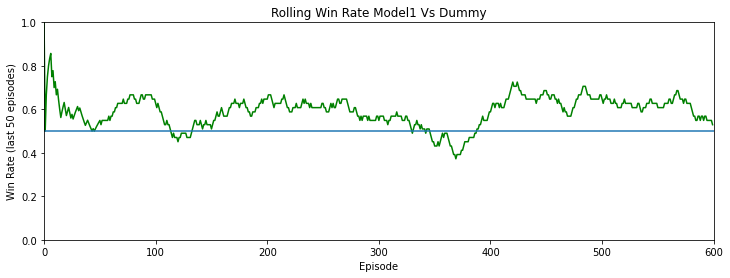

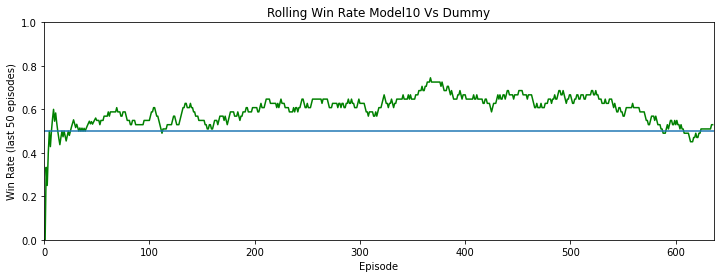

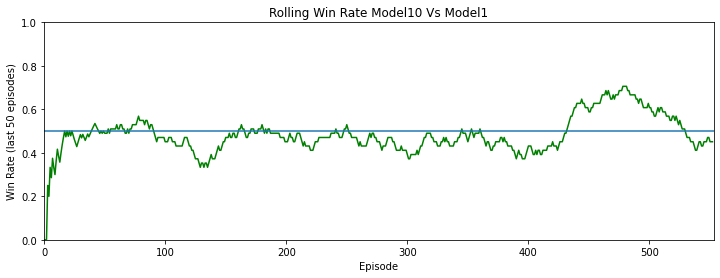

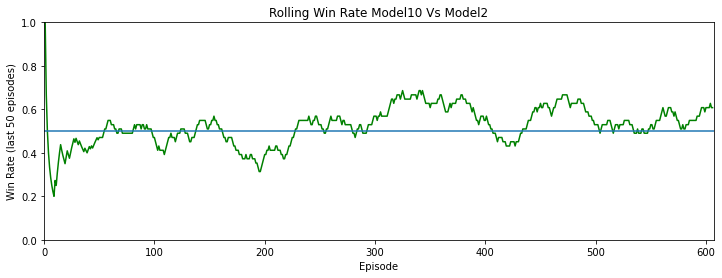

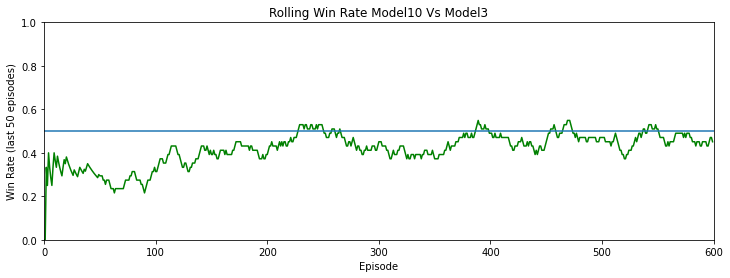

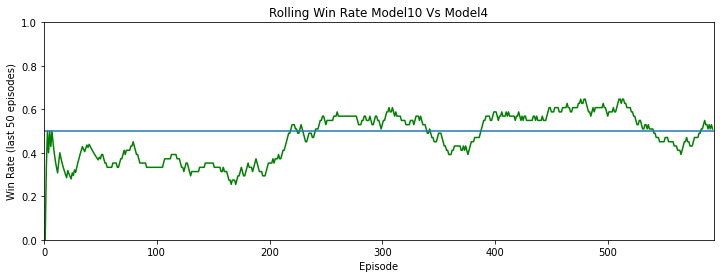

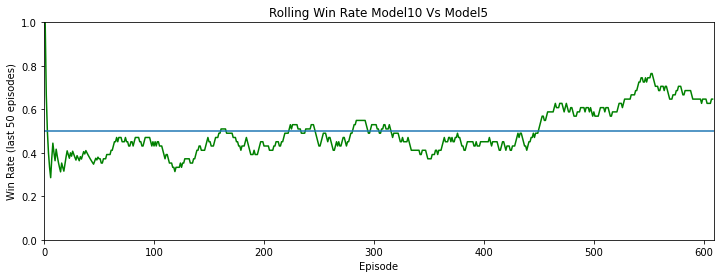

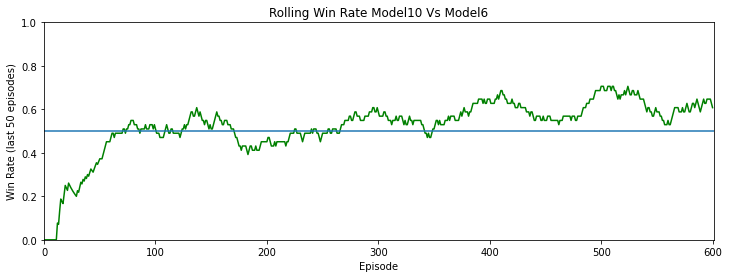

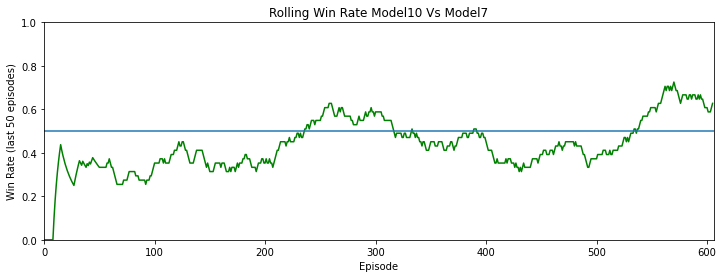

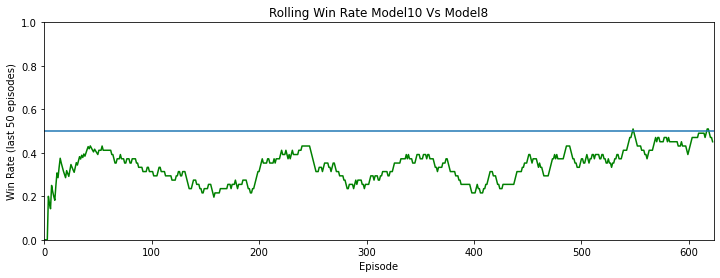

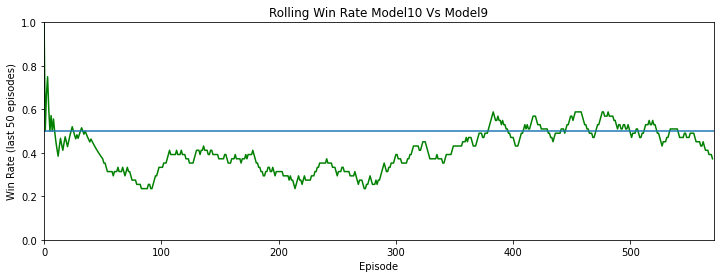

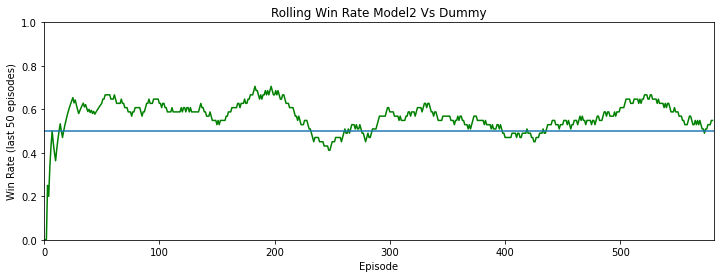

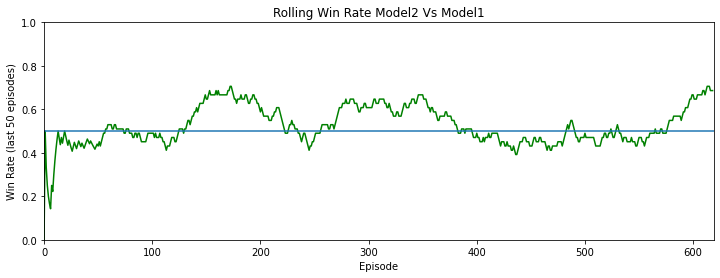

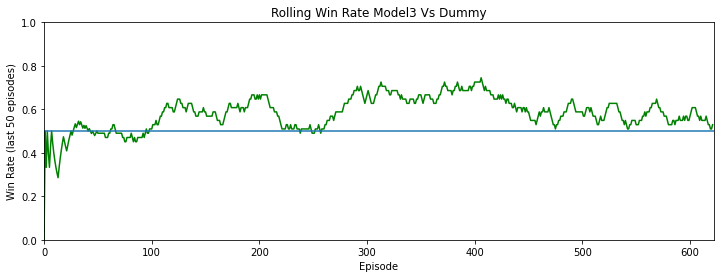

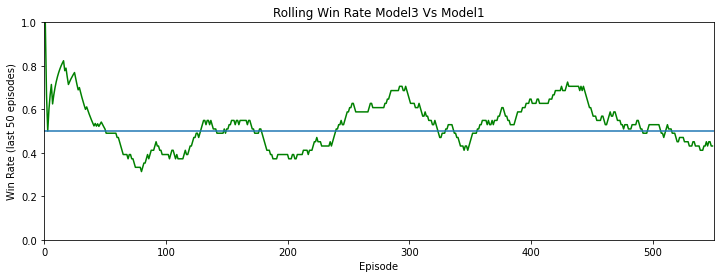

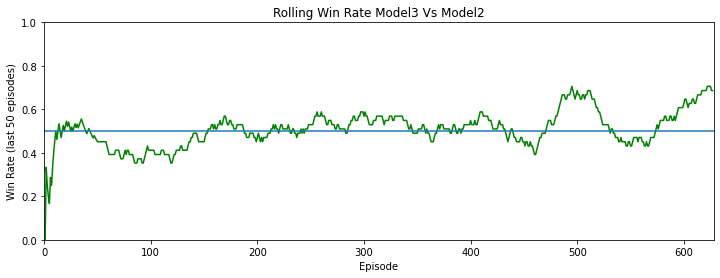

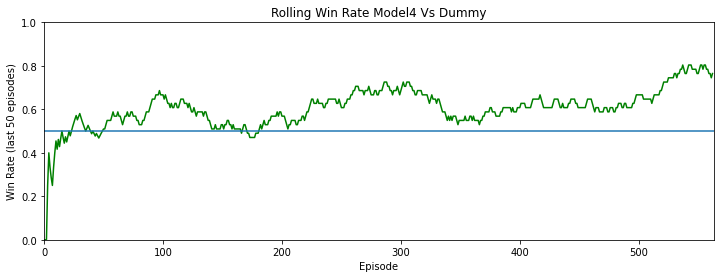

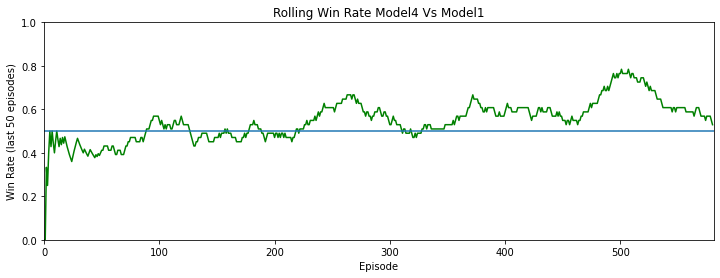

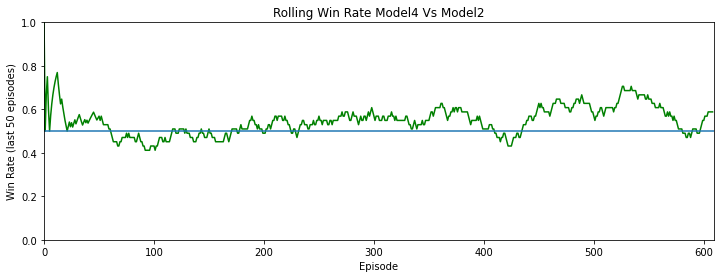

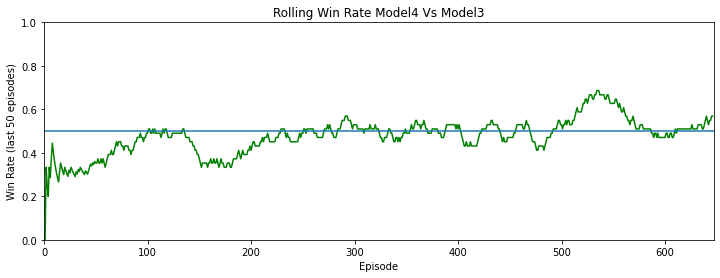

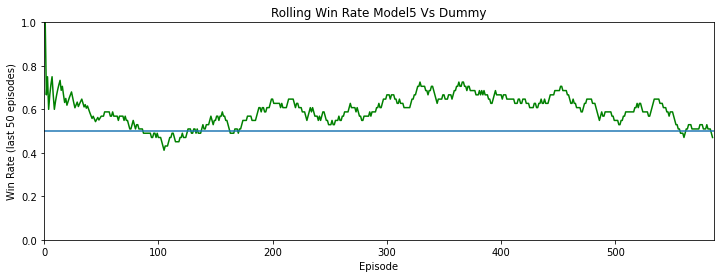

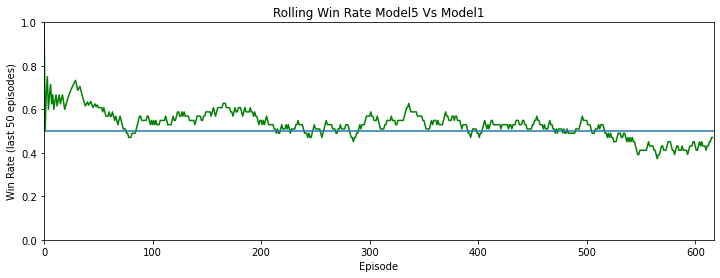

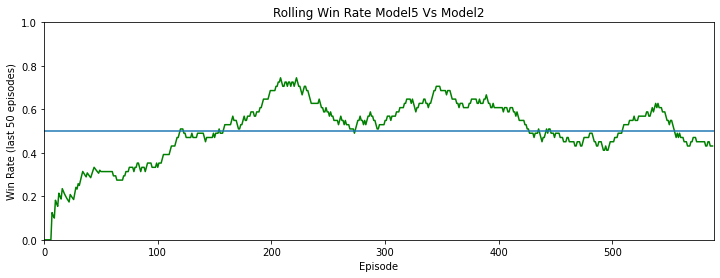

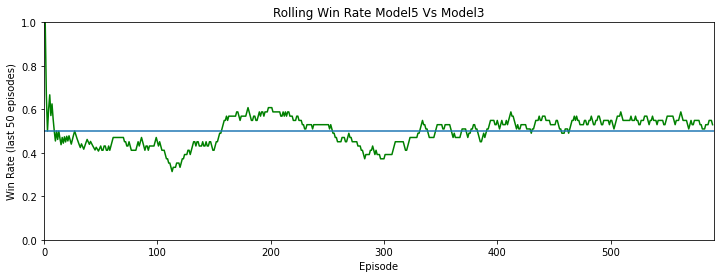

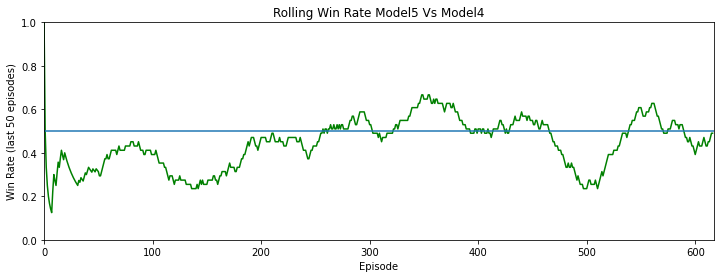

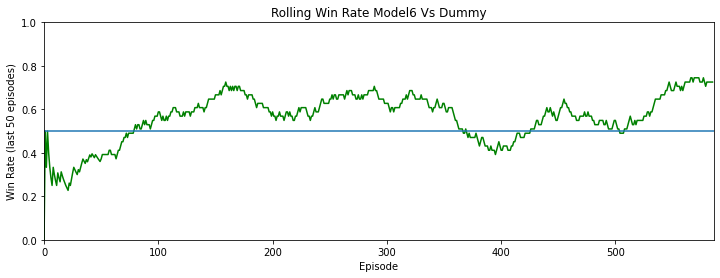

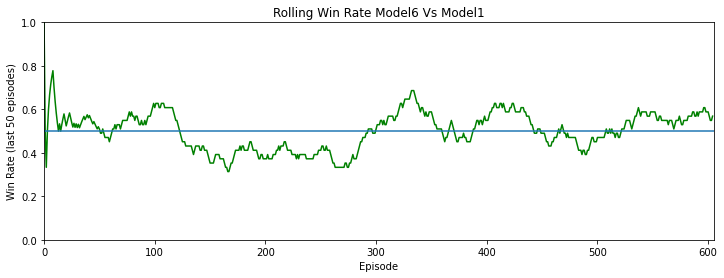

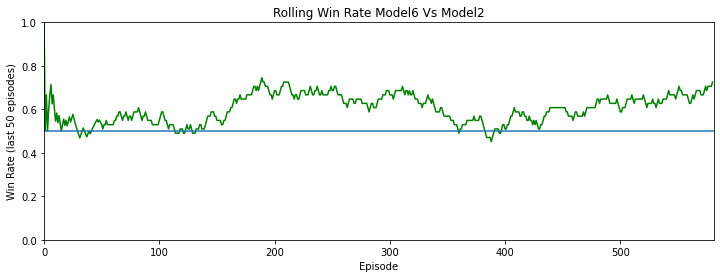

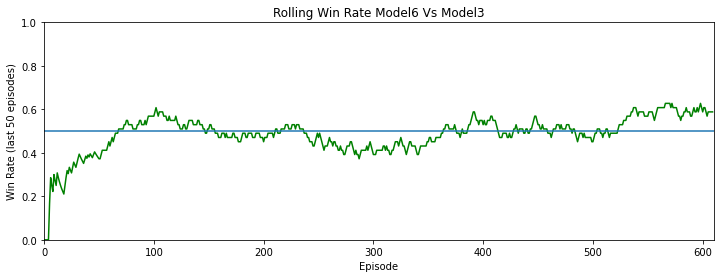

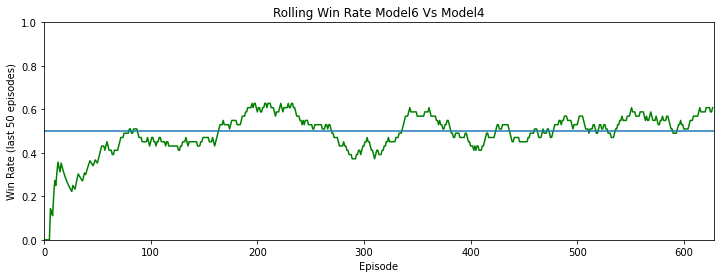

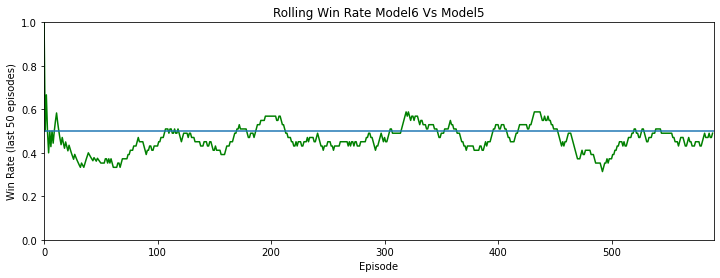

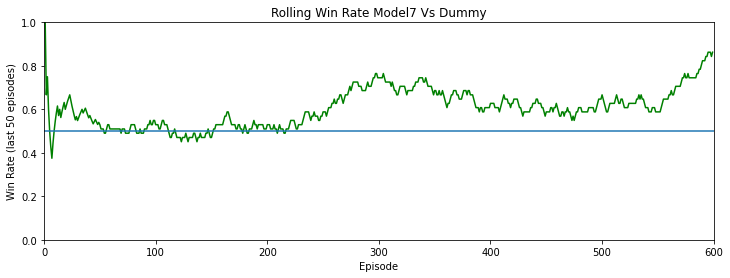

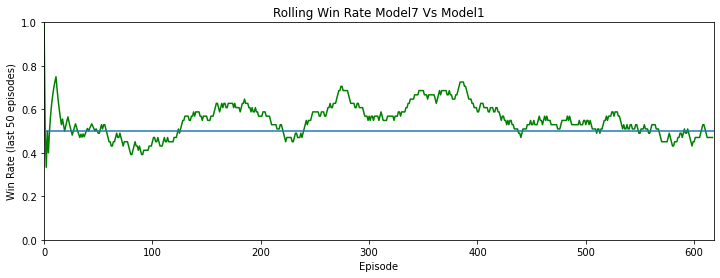

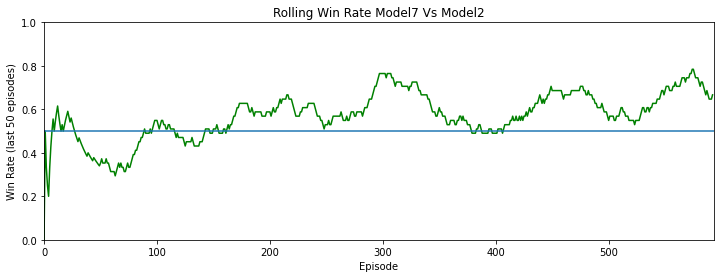

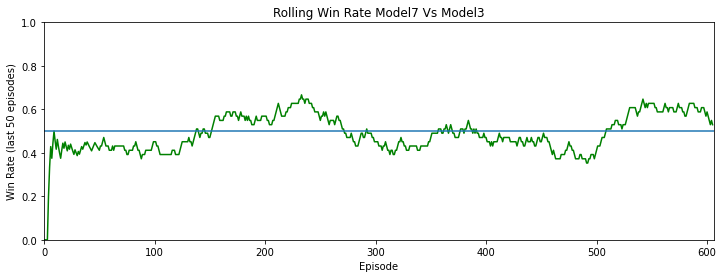

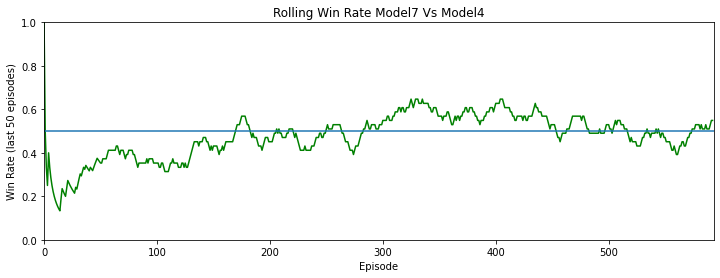

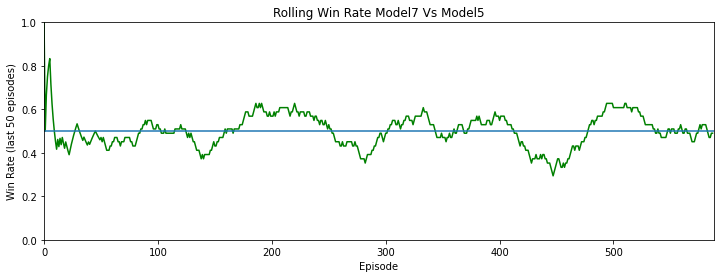

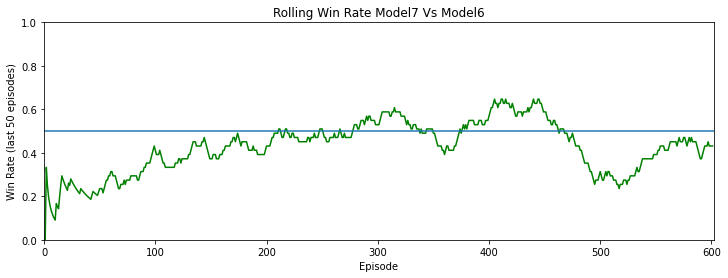

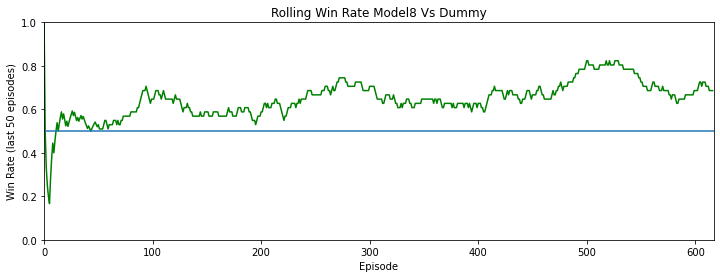

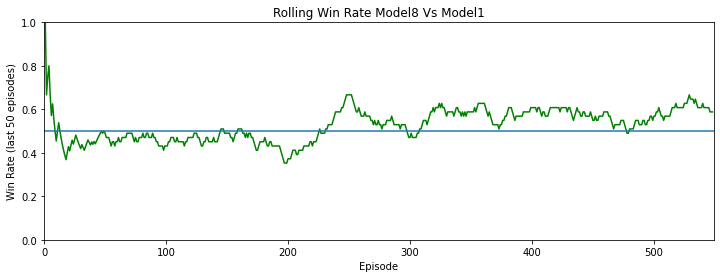

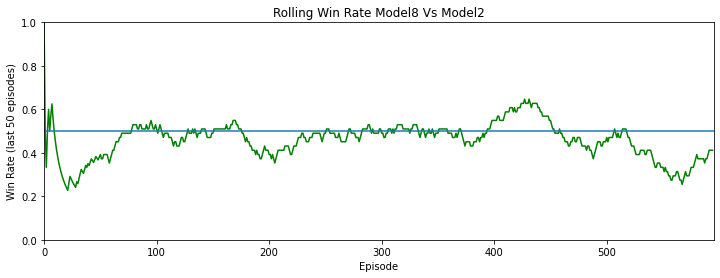

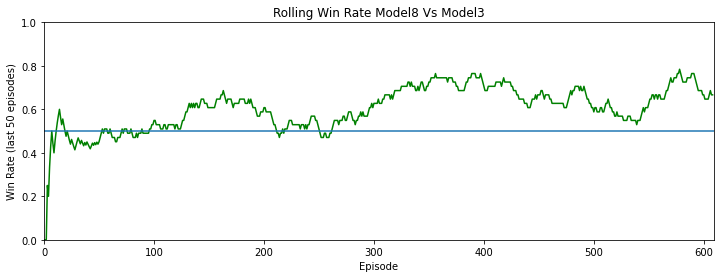

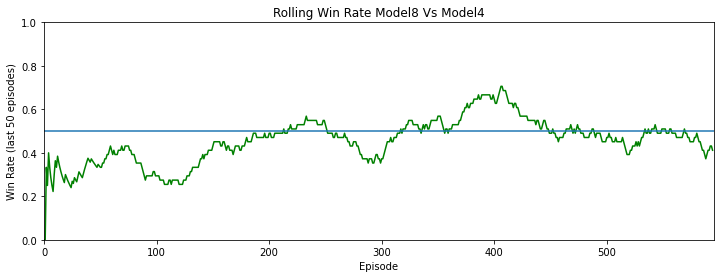

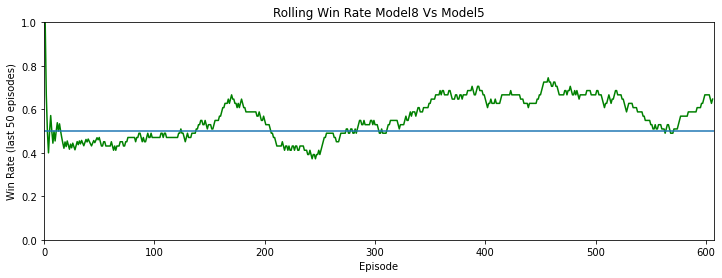

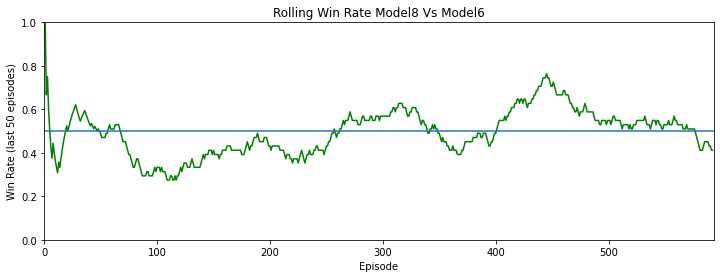

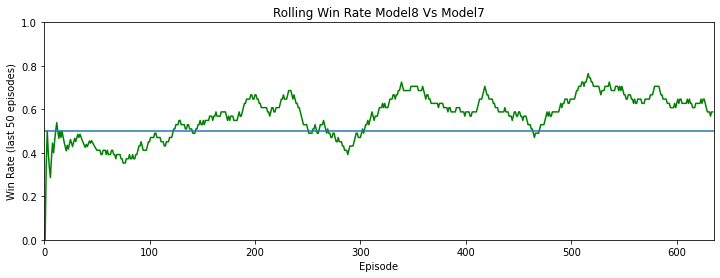

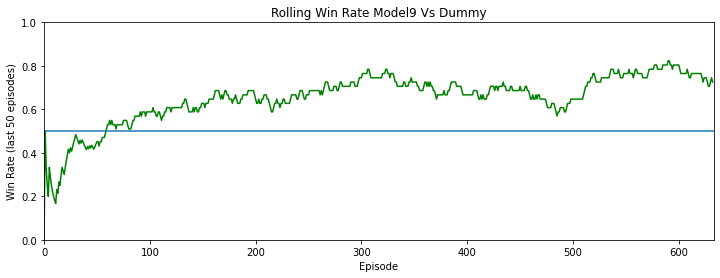

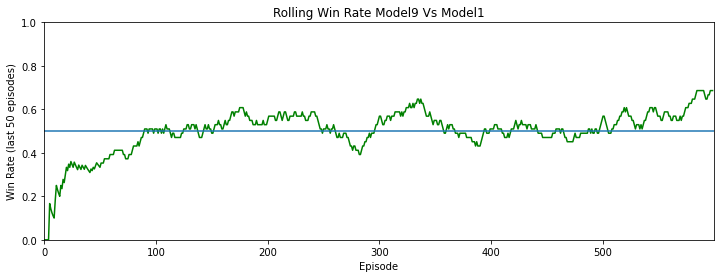

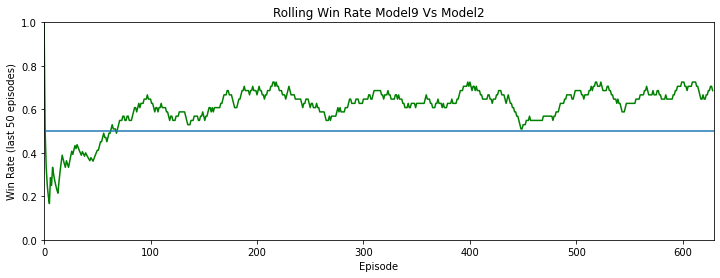

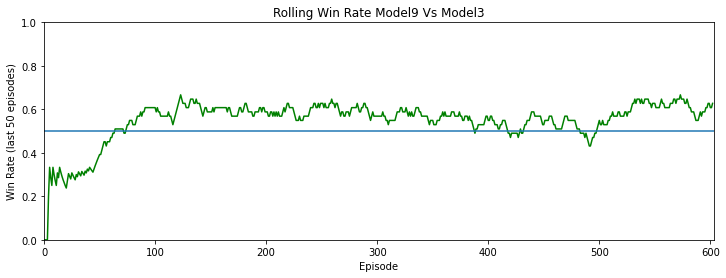

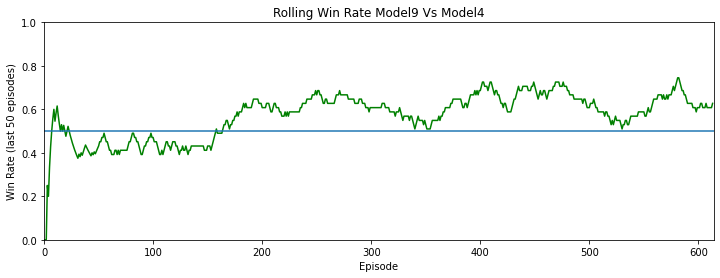

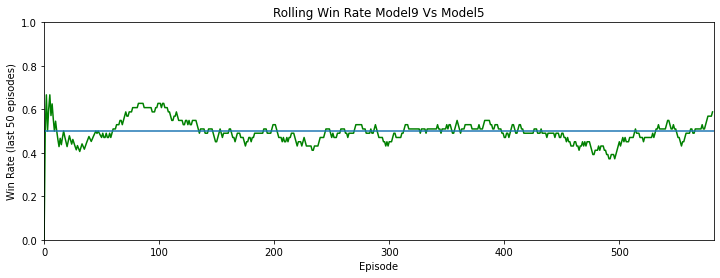

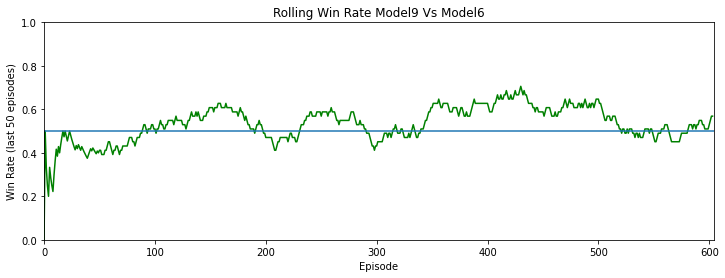

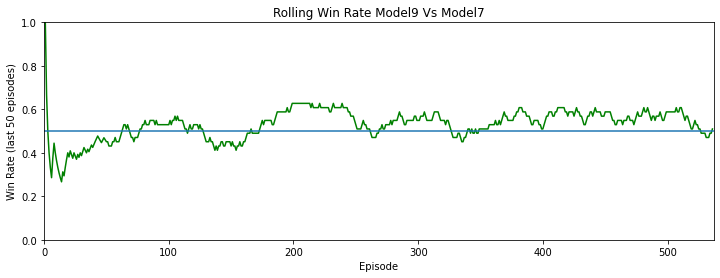

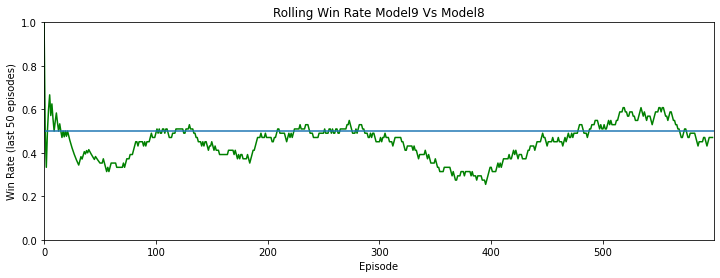

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque



# results is a list of 1=Win, 0=Draw, -1=Loss
for key1 in sorted(resultholder.keys()):
    for key2 in sorted(resultholder[key1].keys()):
        results_array = np.array(resultholder[key1][key2])

        # -----------------------------
        # Option 1: Color-coded scatter plot
        # -----------------------------
        colors = ['green' if r==1 else 'red' if r==-1 else 'blue' for r in results_array]

        # -----------------------------
        # Option 2: Rolling win-rate (smoother)
        # -----------------------------
        window = 50  # rolling window
        win_rate = [np.mean(results_array[max(0,i-window):i+1]==1) for i in range(len(results_array))]

        plt.figure(figsize=(12,4))
        plt.plot(win_rate, color='green')
        plt.plot((0,len(results_array)),(.5,.5))
        plt.xlabel('Episode')
        plt.ylabel('Win Rate (last 50 episodes)')
        plt.title(f'Rolling Win Rate {key1} Vs {key2}')
        plt.ylim(0,1)
        plt.xlim(0,len(results_array))
        plt.show()

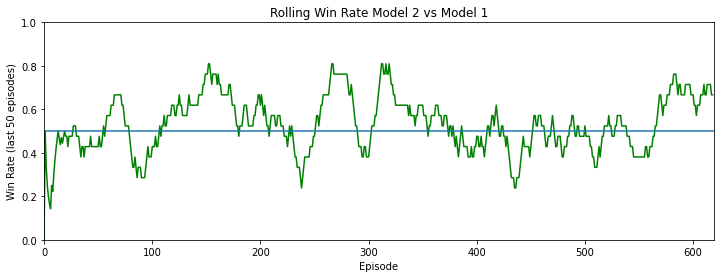

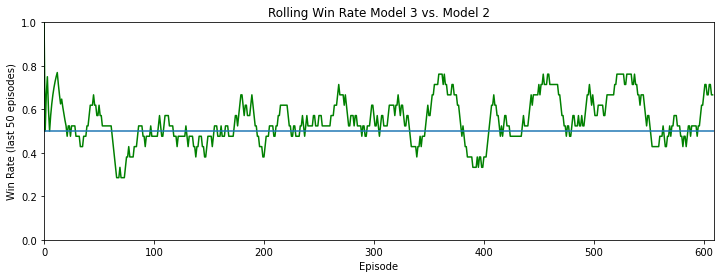

In [23]:
# results is a list of 1=Win, 0=Draw, -1=Loss
results_array = np.array(resultholder["Model2"]["Model1"])

# -----------------------------
# Option 1: Color-coded scatter plot
# -----------------------------
colors = ['green' if r==1 else 'red' if r==-1 else 'blue' for r in results_array]

# -----------------------------
# Option 2: Rolling win-rate (smoother)
# -----------------------------
window = 20  # rolling window
win_rate = [np.mean(results_array[max(0,i-window):i+1]==1) for i in range(len(results_array))]

plt.figure(figsize=(12,4))
plt.plot(win_rate, color='green')
plt.plot((0,len(results_array)),(.5,.5))
plt.xlabel('Episode')
plt.ylabel('Win Rate (last 50 episodes)')
plt.title('Rolling Win Rate Model 2 vs Model 1')
plt.ylim(0,1)
plt.xlim(0,len(results_array))
plt.show()
# results is a list of 1=Win, 0=Draw, -1=Loss
results_array = np.array(resultholder["Model4"]["Model2"])

# -----------------------------
# Option 1: Color-coded scatter plot
# -----------------------------
colors = ['green' if r==1 else 'red' if r==-1 else 'blue' for r in results_array]

# -----------------------------
# Option 2: Rolling win-rate (smoother)
# -----------------------------
window = 20  # rolling window
win_rate = [np.mean(results_array[max(0,i-window):i+1]==1) for i in range(len(results_array))]

plt.figure(figsize=(12,4))
plt.plot(win_rate, color='green')
plt.plot((0,len(results_array)),(.5,.5))
plt.xlabel('Episode')
plt.ylabel('Win Rate (last 50 episodes)')
plt.title('Rolling Win Rate Model 3 vs. Model 2')
plt.ylim(0,1)
plt.xlim(0,len(results_array))
plt.show()

In [24]:
print("The following is the list of snapshots")
print("Columns contain both players' health, both players' mana, and one-hot encoded lists of cards in hand.")
'''snapshot = {

"My_Mana": [self.mana]*length,
"Their_Mana": [opponent.mana]*length,
"My_Health": [self.base_health]*length,
"Their_Health": [opponent.base_health]*length,
"Their_Card_Types_Seen":encodehand(enemy_list) ,
"Their_Currently_Visible_Cards": encodedeployed(opponent.available_squares),
"Active_Cards":encodedeployed(self.available_squares),
"Deck":encodehand(self.deck),
"Action Taken":encodemove(self.move)
}'''
import torch



The following is the list of snapshots
Columns contain both players' health, both players' mana, and one-hot encoded lists of cards in hand.


In [25]:
1e-2

0.01